# Permutation Flow-Shop Scheduling Problem

This is a variant of the Flot-shop scheduling problem (FSSP) in which the sequence of jobs is the same in every machine.

$$
 \begin{align}
     \text{min} \quad & C_{\text{max}} \\
     \text{s.t.} \quad & x_{m-1, j} + p_{m, j} \leq x_{m, j}
         & \forall ~ j \in J; m \in (2, ..., |M|)\\
     & x_{m, j} + p_{m, j} \leq x_{m, k} \lor x_{m, k} + p_{m, k} \leq x_{m, j}
         & \forall ~ j \in J; k \in J, j \neq k\\
     & x_{|M|, j} + p_{|M|, j} \leq C_{\text{max}}
         & \forall ~ j \in J\\
     & x_{m, j} \geq 0 & \forall ~ j \in J; m \in M\\
     & z_{j, k} \in \{0, 1\} & \forall ~ j \in J; k \in J, j \neq k\\
 \end{align}
 $$

 You can compare this implementation to MILP solvers at the [end of the notebook](#bonus---milp-model).

In [1]:
import json

from bnbprob.pfssp import CallbackBnB, plot_gantt
from bnbprob.pfssp.plot import draw_gantt_gif
from bnbprob.pfssp.pypure.heuristics import neh_history
from bnbprob.pfssp.pypure.problem import PermFlowShop
from bnbpy import configure_logfile

In [2]:
configure_logfile("pfssp-bench.log", mode="w")

In [3]:
with open("./../data/flow-shop/reC11.json", mode="r", encoding="utf8") as f:
    p = json.load(f)

print(f"{len(p)} Jobs; {len(p[0])} Machines")

20 Jobs; 10 Machines


In [9]:
problem = PermFlowShop.from_p(p, constructive='neh')
history = neh_history(problem.solution.perm)

In [10]:
draw_gantt_gif(
    history,
    dpi=120,
    figsize=[8, 3],
    seed=42,
    label_cols=2,
    max_label=0,
    filename='pfssp.gif',
    duration=500,
)

In [ ]:
bnb = CallbackBnB(
    eval_node='in', rtol=0.0001, restart_freq=200, save_tree=False
)
sol = bnb.solve(problem)

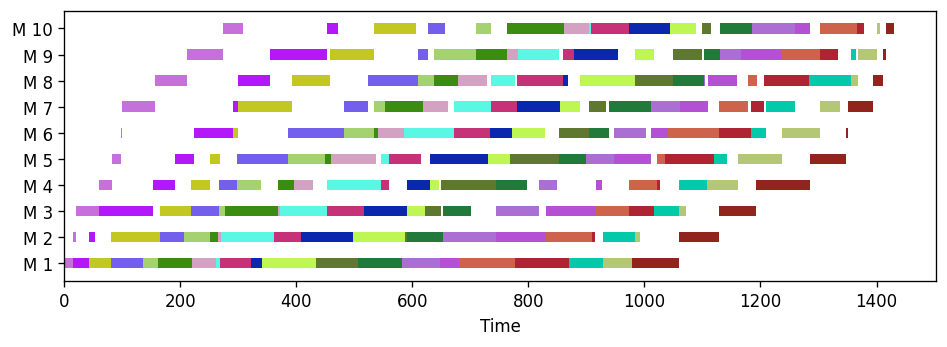

In [8]:
plot_gantt(sol.sequence, dpi=120, seed=42, figsize=[8, 3])